### <span style="color:red"><b>FRAUD_PRED--Predicting Fraudulent Transactions</b></span> 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample

### <span style="color:green">DATA INGESTION </span> 

In [4]:
df = pd.read_csv("Fraud.csv")

####  <span style="color:green">DATA WRANGLING AND ANALYSIS</span> 

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df=df.set_axis(['Step','Mode','Amount','Org_AccountID','Org_OldBalance','Org_NewBalance','Dest_AccountID','Dest_OldBalance','Dest_NewBalance','isFraud','FlaggedFraud'],axis=1 )

In [24]:
df.head(2)

,Step,Mode,Amount,Org_AccountID,Org_OldBalance,Org_NewBalance,Dest_AccountID,Dest_OldBalance,Dest_NewBalance,isFraud,FlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0


####  <span style="color:green"><i>DATA COMPLETENESS(Checking for null values)</i></span> 

In [25]:
df.isnull().sum()

Step               0
Mode               0
Amount             0
Org_AccountID      0
Org_OldBalance     0
Org_NewBalance     0
Dest_AccountID     0
Dest_OldBalance    0
Dest_NewBalance    0
isFraud            0
FlaggedFraud       0
dtype: int64

#### <span style="color:green"><i>DATA CONSISTENCY(Analysing Data Types) </i></span> 

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Step             int64  
 1   Mode             object 
 2   Amount           float64
 3   Org_AccountID    object 
 4   Org_OldBalance   float64
 5   Org_NewBalance   float64
 6   Dest_AccountID   object 
 7   Dest_OldBalance  float64
 8   Dest_NewBalance  float64
 9   isFraud          int64  
 10  FlaggedFraud     int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


#### <span style="color:green"><i>DATA UNIQUENESS(Checking for duplicate rows) </i></span>

In [27]:
duplicates = df[df.duplicated()]

print(duplicates)

Empty DataFrame
Columns: [Step, Mode, Amount, Org_AccountID, Org_OldBalance, Org_NewBalance, Dest_AccountID, Dest_OldBalance, Dest_NewBalance, isFraud, FlaggedFraud]
Index: []


#### <span style="color:green"><i>OUTLIERS DETECTION</i></span>

In [28]:
def find_outliers(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)][column]
    return outliers

# Columns to check for outliers
columns = ['Amount','Org_OldBalance','Org_NewBalance' ,'Dest_OldBalance' , 'Dest_NewBalance']

# Find and print outliers for each column
for column in columns:
    outliers = find_outliers(df, column)
    print(f"Outliers in {column}:")
    print(outliers.max())
    print()

Outliers in Amount:
92445516.64

Outliers in Org_OldBalance:
59585040.37

Outliers in Org_NewBalance:
49585040.37

Outliers in Dest_OldBalance:
356015889.35

Outliers in Dest_NewBalance:
356179278.92



###### Large transaction amounts may not necessarily be fraudulent. Large companies or individuals may make high-value transactions.If the outliers are extreme but valid (i.e., they actually represent real transactions), removing them may bias the model. Fraudulent transactions are often characterized by unusual patterns, so dropping these outliers may lead to missing important fraud signals.

#### <span style="color:green"><i>Analyzing the data</i></span>

In [35]:
df['Mode'].value_counts()

Mode
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

#### <span style="color:green"><i>Analyzing data only for the fraud cases</i></span> 

In [39]:
fraudulent_df = df[(df['isFraud'] == 1) & (df['FlaggedFraud']==1)]
isfrd=fraudulent_df.sort_values(by='Amount',ascending=False)
isfrd

,Step,Mode,Amount,Org_AccountID,Org_OldBalance,Org_NewBalance,Dest_AccountID,Dest_OldBalance,Dest_NewBalance,isFraud,FlaggedFraud
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1
6362460,730,TRANSFER,10000000.00,C2140038573,17316255.05,17316255.05,C1395467927,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6362462,730,TRANSFER,7316255.05,C1869569059,17316255.05,17316255.05,C1861208726,0.0,0.0,1,1
6362584,741,TRANSFER,5674547.89,C992223106,5674547.89,5674547.89,C1366804249,0.0,0.0,1,1
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6296014,671,TRANSFER,3441041.46,C917414431,3441041.46,3441041.46,C1082139865,0.0,0.0,1,1


In [40]:
df['FlaggedFraud'].groupby(df['Mode']).value_counts().unstack()

FlaggedFraud,0,1
Mode,,
CASH_IN,1399284.0,NaN
CASH_OUT,2237500.0,NaN
DEBIT,41432.0,NaN
PAYMENT,2151495.0,NaN
TRANSFER,532893.0,16.0


#### <span style="color:green"><i>From above we can conclude that system captures fraudulent transaction that occurs through transfer. Same is being claimed by the company.</i></span>

##  <span style="color:red"><b>Feature Engineering<b></span> 

##  <span style="color:blue"><i>1. Feature Selection (Chi2 and Pearson Correlation)</i></span> 

###  <span style="color:green"><i>Feature selection (Analyzing features using pearson correlation and feature importance)</i></span> 

In [41]:
numerical_features = df[ ['Amount','Org_OldBalance','Org_NewBalance' ,'Dest_OldBalance' , 'Dest_NewBalance']]

# Compute correlation matrix
correlation_matrix = numerical_features.corr()

# Display correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = numerical_features.columns
vif_data["VIF"] = [variance_inflation_factor(numerical_features.values, i) for i in range(len(numerical_features.columns))]

# Display VIF
print("\nVariance Inflation Factors (VIF):")
print(vif_data)

Correlation Matrix:
                   Amount  Org_OldBalance  Org_NewBalance  Dest_OldBalance  \
Amount           1.000000       -0.002762       -0.007861         0.294137   
Org_OldBalance  -0.002762        1.000000        0.998803         0.066243   
Org_NewBalance  -0.007861        0.998803        1.000000         0.067812   
Dest_OldBalance  0.294137        0.066243        0.067812         1.000000   
Dest_NewBalance  0.459304        0.042029        0.041837         0.976569   

                 Dest_NewBalance  
Amount                  0.459304  
Org_OldBalance          0.042029  
Org_NewBalance          0.041837  
Dest_OldBalance         0.976569  
Dest_NewBalance         1.000000  

Variance Inflation Factors (VIF):
           Feature         VIF
0           Amount    3.861988
1   Org_OldBalance  464.011728
2   Org_NewBalance  465.356124
3  Dest_OldBalance   70.452251
4  Dest_NewBalance   82.167173


<function matplotlib.pyplot.show(close=None, block=None)>

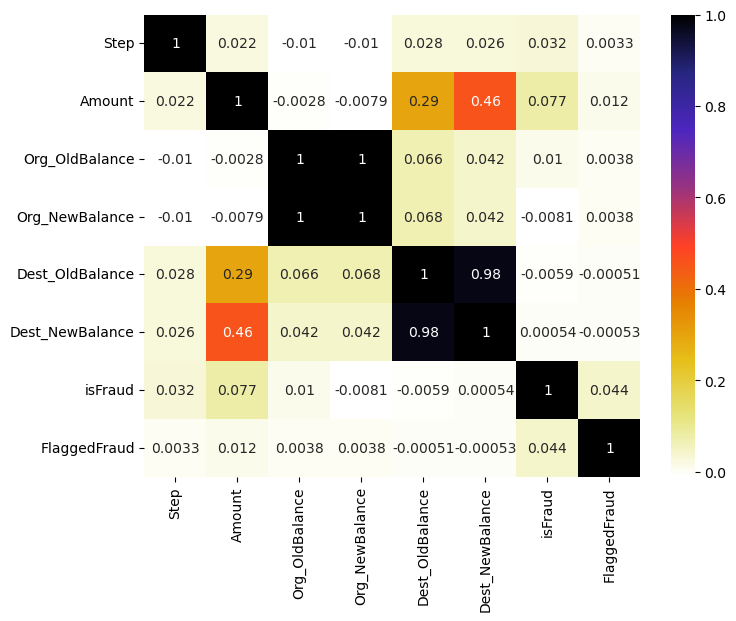

In [43]:
plt.figure(figsize=(8,6))
numeric_columns=['Step','Mode','Amount','Org_AccountID','Org_OldBalance','Org_NewBalance','Dest_AccountID','Dest_OldBalance','Dest_NewBalance','isFraud','FlaggedFraud']
numeric_columns = df.select_dtypes(include=['number'])


cor = numeric_columns.corr()

sns.heatmap(cor,annot=True, cmap=plt.cm.CMRmap_r)
plt.show


#### Positive correlation between amount and oldbalance dest suggest that larger transaction amounts are associated with higher
#### intial balance in the desitination account


#### positive correlation (0.976) between 'oldbalanceDest' and 'newbalanceDest', 
#### indicating that the initial balance in the destination account strongly 
#### predicts the new balance after the transaction

#### positive correlation (0.459) between 'amount' and 'newbalanceDest', 
#### indicating that larger transaction amounts 
#### are associated with higher new balances in the destination account.

#### Correlation between 'amount' and 'oldbalanceOrg' as well as 'newbalanceOrig' 
#### is very weak (close to 0), suggesting little to no linear 
#### relationship between transaction amount and the originator's initial or new balance.



#### correlation between 'amount' and 'oldbalanceOrg' as well as 
#### 'newbalanceOrig' is very weak (close to 0), 
#### suggesting little to no linear relationship 

#### correlation between 'oldbalanceOrg' and 'oldbalanceDest', as well as 'newbalanceOrig' 
#### and 'newbalanceDest', 
#### is also weak (0.066 and 0.042 respectively), indicating

###  <span style="color:green"><i>Ranking features on Importance</i></span> 

#####  <span style="color:green"><i>Encoding categorical values</i></span> 

In [9]:
categorical_features = ['Mode','Org_AccountID','Dest_AccountID']
# Initialize a dictionary to hold label encoders
label_encoders = {}

# Iterate over categorical features and encode them
for feature in categorical_features:
    # Initialize LabelEncoder for the feature
    le = LabelEncoder()
    # Fit and transform the feature
    df[feature] = le.fit_transform(df[feature])
    # Store the label encoder in the dictionary
    label_encoders[feature] = le
    # Print the label encoding mapping
    label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    
    print(f"Label encoding mapping for {feature} (first 10):", dict(list(label_mapping.items())[:10]))
    

Label encoding mapping for Mode (first 10): {'CASH_IN': 0, 'CASH_OUT': 1, 'DEBIT': 2, 'PAYMENT': 3, 'TRANSFER': 4}
Label encoding mapping for Org_AccountID (first 10): {'C1000000639': 0, 'C1000001337': 1, 'C1000001725': 2, 'C1000002591': 3, 'C1000003372': 4, 'C1000003615': 5, 'C1000004053': 6, 'C1000004530': 7, 'C1000005353': 8, 'C1000005555': 9}
Label encoding mapping for Dest_AccountID (first 10): {'C1000004082': 0, 'C1000004940': 1, 'C1000013769': 2, 'C100001587': 3, 'C1000015936': 4, 'C1000022185': 5, 'C1000026379': 6, 'C1000030947': 7, 'C100003532': 8, 'C1000038153': 9}


In [66]:
X= df.drop(columns=['isFraud'])
y=df['isFraud']

In [ ]:
X_train , X_test ,y_train, y_test= train_test_split(X,y,test_size=0.3, random_state=0)
X_train.shape, X_test.shape

In [51]:
ordered_rank_features= SelectKBest(score_func=chi2,k=10)
ordered_features= ordered_rank_features.fit(X,y)
dfscores=pd.DataFrame (ordered_features.scores_,columns=['Scores'])     

In [52]:
dfscores=pd.DataFrame (ordered_features.scores_,columns=['Scores'])
dfcolumns=pd.DataFrame(X.columns)
features_rank=pd.concat([dfcolumns,dfscores],axis=1)
features_rank.sort_values(by='Scores',ascending=False)

,0,Scores
2,Amount,7.586237e+10
4,Org_OldBalance,6.563092e+09
5,Org_NewBalance,4.223772e+09
6,Dest_AccountID,2.314492e+09
7,Dest_OldBalance,2.313389e+09
8,Dest_NewBalance,2.009466e+07
3,Org_AccountID,1.449133e+06
0,Step,5.280591e+05
9,FlaggedFraud,1.237922e+04
1,Mode,2.936631e+03


###  <span style="color:green"><i>Visualzing feature importance using extra tree classifier</i></span> 

In [53]:
model=ExtraTreesClassifier()
model.fit(X,y)

ExtraTreesClassifier()

In [54]:
print(model.feature_importances_)

[0.13131084 0.02640401 0.1855641  0.04232256 0.2792526  0.05873553
 0.04431195 0.05661627 0.17389771 0.00158443]


<Axes: >

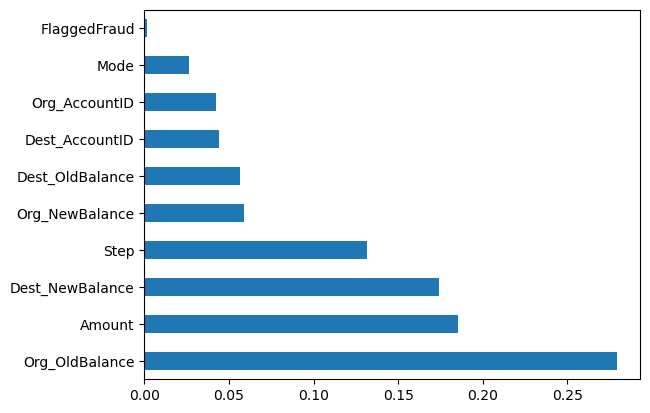

In [55]:
ranked_features_index = pd.Series(model.feature_importances_, index=X.columns)
ranked_features = ranked_features_index.nlargest(10)
ranked_features.plot(kind='barh')

##### After analyzing feature importance through chi2 we found out of 'oldbalanceDest' and 'newbalanceDest'& oldbalanceOrg' as well as 'newbalanceOrig'
##### showing  high collinearity.oldbalanceDest and newbalanceOrig are less important.

##### We will try reducing the dimensionality using PCA . 

##### Will evaluate performance of both the case on randomforest using classification metrics to see the variations<span 

### <span style="color:green"><i>Dropping Columns</i> </span> 

### <span style="color:green"><i>Randomforest Model </i></span> 

In [67]:
# Define feature set and target variable

sample_size = 10000
target_variable = 'isFraud'
df_sampled = df.sample(n=sample_size, random_state=42)

X = df_sampled.drop(columns=[target_variable, 'Org_NewBalance', 'Dest_OldBalance'])  # Drop the specified columns here
y = df_sampled[target_variable]

# Split the sampled dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = rf_model.predict(X_test)

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_test, y_val_pred)
val_precision = precision_score(y_test, y_val_pred, average='weighted')
val_recall = recall_score(y_test, y_val_pred, average='weighted')
val_f1 = f1_score(y_test, y_val_pred, average='weighted')

print("Testing Set Metrics:")
print("Accuracy:", val_accuracy)
print("Precision:", val_precision)
print("Recall:", val_recall)
print("F1 Score:", val_f1)


Testing Set Metrics:
Accuracy: 0.999
Precision: 0.99900100050025
Recall: 0.999
F1 Score: 0.9987502502502502



#### <span style="color:green"><i>Applied Principal Component Analysis (PCA) to combine oldbalanceOrg, newbalanceOrig, oldbalanceDest, and newbalanceDest into two principal components.</i></span> 

### <span style="color:green"><i>Feature Extraction using PCA and Model Evaluation</i></span> 

In [56]:
features_group1 = ['Org_OldBalance','Org_NewBalance']
features_group2 = ['Dest_OldBalance','Dest_NewBalance']

# Standardize the features in each group
scaler1 = StandardScaler()
df_scaled_group1 = scaler1.fit_transform(df[features_group1])

scaler2 = StandardScaler()
df_scaled_group2 = scaler2.fit_transform(df[features_group2])

# Apply PCA to each group
pca1 = PCA(n_components=1)  # Reduce to 1 principal component
df_pca_group1 = pca1.fit_transform(df_scaled_group1)

pca2 = PCA(n_components=1)  # Reduce to 1 principal component
df_pca_group2 = pca2.fit_transform(df_scaled_group2)

# Create DataFrames with the principal components
df_pca_group1 = pd.DataFrame(df_pca_group1, columns=['PCA_Component_Group1'])
df_pca_group2 = pd.DataFrame(df_pca_group2, columns=['PCA_Component_Group2'])

# Drop the original features from the DataFrame
df_dropped = df.drop(columns=features_group1 + features_group2)

# Concatenate the principal components with the rest of the DataFrame
df_final = pd.concat([df_dropped, df_pca_group1, df_pca_group2], axis=1)

print(df_final.head())

   Step  Mode    Amount  Org_AccountID  Dest_AccountID  isFraud  FlaggedFraud  \
0     1     3   9839.64         757869         1662094        0             0   
1     1     3   1864.28        2188998         1733924        0             0   
2     1     4    181.00        1002156          439685        1             0   
3     1     1    181.00        5828262          391696        1             0   
4     1     3  11668.14        3445981          828919        0             0   

   PCA_Component_Group1  PCA_Component_Group2  
0             -0.330524             -0.464728  
1             -0.401051             -0.464728  
2             -0.410897             -0.464728  
3             -0.410897             -0.460322  
4             -0.393540             -0.464728  


### <span style="color:green">Model using PCA</span> 

In [57]:
sample_size = 10000
target_variable = 'isFraud'
df_sampled = df_final.sample(n=sample_size, random_state=42)  # Random sampling without replacement

# Separate features and target variable
X = df_sampled.drop(target_variable, axis=1)
y = df_sampled[target_variable]

# Split the sampled dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [59]:
### EVALUATING PCA MODEL

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = rf_model.predict(X_val)

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='weighted')
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

print("Validation Set Metrics:")
print("Accuracy:", val_accuracy)
print("Precision:", val_precision)
print("Recall:", val_recall)
print("F1 Score:", val_f1)
print()

# Make predictions on the testing set
y_test_pred = rf_model.predict(X_test)

# Evaluate the model on the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print("Testing Set Metrics:")
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 Score:", test_f1)
print()

Validation Set Metrics:
Accuracy: 0.998
Precision: 0.998004005340454
Recall: 0.998
F1 Score: 0.9975724309102191

Testing Set Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0



## <span style="color:blue"><b>Conclusions::</b></span> 
### <span style="color:green"><i>1. Compared Random Forest models with and without PCA.</i></span> 
### <span style="color:green"><i>2. Selected the model without PCA for better interpretability</i></span> 


##  <span style="color:blue"><b>Model Selection<b></span> 

### <span style="color:green"><i>ADABOOST ||| XGBOOST ||| GRADIENTBOOST || RANDOMFOREST</i></span> 

In [13]:
sample_size = 10000
target_variable = 'isFraud'
df_sampled = df.sample(n=sample_size, random_state=42)

X = df_sampled.drop(columns=[target_variable, 'Org_NewBalance', 'Dest_OldBalance'])  # Drop the specified columns here
y = df_sampled[target_variable]

# Split the sampled dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#### <span style="color:green"><i>ADABOOST </i></span> 

In [18]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
ad_model=AdaBoostClassifier()

ad_model.fit(X_train, y_train)
y_val_pred = ad_model.predict(X_val)

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='weighted')
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

print("Validation Set Metrics:")
print("Accuracy:", val_accuracy)
print("Precision:", val_precision)
print("Recall:", val_recall)
print("F1 Score:", val_f1)
print()

# Make predictions on the testing set
y_test_pred = ad_model.predict(X_test)

# Evaluate the model on the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print("Testing Set Metrics:")
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 Score:", test_f1)
print()

C:\Anaconda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Validation Set Metrics:
Accuracy: 0.9986666666666667
Precision: 0.9986684480071253
Recall: 0.9986666666666667
F1 Score: 0.9985004456327986

Testing Set Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0



#### <span style="color:green"><i>XGBOOST </i></span> 

In [15]:
xg_model= GradientBoostingClassifier()
xg_model.fit(X_train, y_train)
y_val_pred = xg_model.predict(X_val)

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='weighted')
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

print("Validation Set Metrics:")
print("Accuracy:", val_accuracy)
print("Precision:", val_precision)
print("Recall:", val_recall)
print("F1 Score:", val_f1)
print()

# Make predictions on the testing set
y_test_pred = xg_model.predict(X_test)

# Evaluate the model on the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print("Testing Set Metrics:")
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 Score:", test_f1)
print()

Validation Set Metrics:
Accuracy: 0.9966666666666667
Precision: 0.9963346702317292
Recall: 0.9966666666666667
F1 Score: 0.9964820387087187

Testing Set Metrics:
Accuracy: 0.9993333333333333
Precision: 1.0
Recall: 0.9993333333333333
F1 Score: 0.9996665555185063



C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### <span style="color:green"><i> GRADIENTBOOST</i></span> 

In [16]:
gdb_model= GradientBoostingClassifier()
gdb_model.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = gdb_model.predict(X_val)

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='weighted')
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

print("Validation Set Metrics:")
print("Accuracy:", val_accuracy)
print("Precision:", val_precision)
print("Recall:", val_recall)
print("F1 Score:", val_f1)
print()

# Make predictions on the testing set
y_test_pred = gdb_model.predict(X_test)

# Evaluate the model on the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print("Testing Set Metrics:")
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 Score:", test_f1)
print()

Validation Set Metrics:
Accuracy: 0.998
Precision: 0.998004005340454
Recall: 0.998
F1 Score: 0.9975724309102191

Testing Set Metrics:
Accuracy: 0.9986666666666667
Precision: 1.0
Recall: 0.9986666666666667
F1 Score: 0.9993328885923949



C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### <span style="color:green"><i> RANDOMFOREST</i></span> 

In [21]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = rf_model.predict(X_val)

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='weighted')
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

print("Validation Set Metrics:")
print("Accuracy:", val_accuracy)
print("Precision:", val_precision)
print("Recall:", val_recall)
print("F1 Score:", val_f1)
print()

# Make predictions on the testing set
y_test_pred = rf_model.predict(X_test)

# Evaluate the model on the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print("Testing Set Metrics:")
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 Score:", test_f1)
print()

Validation Set Metrics:
Accuracy: 0.9973333333333333
Precision: 0.9973404491883479
Recall: 0.9973333333333333
F1 Score: 0.9964462257849032

Testing Set Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0



### <span style="color:green"><b><i>Xgboost Model for FRAUD DETECTION</i></b></span> 

In [66]:
print("Fraud Detection ")
a = float(input("step (1-744)   : "))
b = float(input("Type of Transaction (Cash_in = 0, Cash_out = 1, Debit=2 ,Payment=3, Transfer=4) : "))
c = float(input("Amount(Amount of Transaction)	: "))
d = float(input("NameOrig(Id of Customer intiating Transaction)  : "))
e = float(input("Old_balalnce(Balance Before Transaction)	: "))
f = float(input("Name_Dest(Recepient Account): "))
g = float(input("New_Balance_Dest(Recepient Account Balance)	: "))
h = float(input("Flagged_Fraud(YES:1 ,NO:0)	: "))


features = np.array([[a, b, c, d, e,f,g,h]])
print("FRAUD TRANSACTION::: ", xg_model.predict(features))

Fraud Detection 


step (1-744)   :  744
Type of Transaction (Cash_in = 0, Cash_out = 1, Debit=2 ,Payment=3, Transfer=4) :  4
Amount(Amount of Transaction)	:  6311409.28
NameOrig(Id of Customer intiating Transaction)  :  1737278
Old_balalnce(Balance Before Transaction)	:  6311409.28
Name_Dest(Recepient Account):  2600949
New_Balance_Dest(Recepient Account Balance)	:  0.00
Flagged_Fraud(YES:1 ,NO:0)	:  1


FRAUD TRANSACTION:::  [1]


####  Evaluated different models: Random Forest, AdaBoost, XGBoost, and Gradient Boosting.
####  Trained and evaluated each model on testing and validation data.

####  <span style="color:blue"><b><i>Result:</i></b></span> 
#### •XGBoost and Gradient Boosting performed similarly well.
#### •Random Forest showed high metrics but also signs of overfitting.
#### •AdaBoost performed well but slightly less effectively.

####  <span style="color:blue"><b><i>Inferences:</i></b></span> 
#### XGBoost is the best choice because it:
#### 1.	Has the highest accuracy, precision, recall, and F1 score on both validation and testing sets.
#### 2.	Offers robust generalization and efficiency, crucial for real-world fraud detection.


In [19]:
xg_model= XGBClassifier() 
xg_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [20]:
import pickle
pickle.dump (xg_model,open('model.pkl','wb'))